In [2]:
import numpy as np
import pandas as pd
import math
import h5py
import matplotlib.pyplot as plt

import torch

#from itertools import product
from pynwb import NWBHDF5IO
from nlb_tools.nwb_interface import NWBDataset

import warnings
warnings.filterwarnings("ignore")

In [3]:
datapath = '/home/makki/data/NWB/000070/sub-Jenkins/sub-Jenkins_ses-20090916_behavior+ecephys.nwb'
dataset = NWBDataset(datapath, split_heldout=False)

Dropping Position_Cursor due to timestamp mismatch.
Dropping Position_Eye due to timestamp mismatch.
Dropping Position_Hand due to timestamp mismatch.
Spikes found outside of observed interval.


In [4]:
datapath = '/home/makki/data/NWB/000070/sub-Jenkins/sub-Jenkins_ses-20090916_behavior+ecephys.nwb'
io = NWBHDF5IO(file=h5py.File(datapath), mode='r', load_namespaces=True)
nwbdata = io.read()

In [5]:
trial_info = dataset.trial_info
for column in trial_info.columns:
    print(column)

trial_id
start_time
end_time
target_presentation_time
go_cue_time
reaction_time
move_begins_time
move_ends_time
discard_trial
task_success
trial_type
trial_version
proto_trial
maze_condition
correct_reach
maze_num_targets
maze_num_barriers
novel_maze
target_positions
frame_details
hit_target_position
target_size
barrier_info
timeseries


In [1]:
trial_info['trial_type'].value_counts()

NameError: name 'trial_info' is not defined

In [27]:
print(f"Total num of trials: {trial_info['trial_id'].size}\n")
print("Count of null values in each column:\n")

dataset.trial_info.isnull().sum()

Total num of trials: 2265

Count of null values in each column:



trial_id                     0
start_time                   0
end_time                     0
target_presentation_time     0
go_cue_time                  0
reaction_time                0
move_begins_time             0
move_ends_time              13
discard_trial                0
task_success                 0
trial_type                   0
trial_version                0
proto_trial                  0
maze_condition               0
correct_reach                0
maze_num_targets             0
maze_num_barriers            0
novel_maze                   0
target_positions             0
frame_details                0
hit_target_position          0
target_size                  0
barrier_info                 0
timeseries                   0
dtype: int64

In [28]:
# The make_trial_data() returns a DataFrame containing trialized data. It has the same fields as the continuous `dataset.data` DataFrame,
# But adds `trial_id`, `trial_time`, and `align_time`. Till here, each row is still a time bin.
# Note: Later we do the cropping and alignment arount move_onset by ourselves.

trial_data = dataset.make_trial_data(allow_nans=True)

for column in trial_data.columns:
    if 'spikes' not in column:
        print(column)

NaNs found in 47.14% of `trial_data`.


('Processed_A001', '0000')
('Processed_A001', '0001')
('Processed_A001', '0002')
('Processed_A001', '0003')
('Processed_A001', '0004')
('Processed_A001', '0005')
('Processed_A001', '0006')
('Processed_A001', '0007')
('Processed_A001', '0008')
('Processed_A001', '0009')
('Processed_A001', '0010')
('Processed_A001', '0011')
('Processed_A001', '0012')
('Processed_A001', '0013')
('Processed_A001', '0014')
('Processed_A001', '0015')
('Processed_A001', '0016')
('Processed_A001', '0017')
('Processed_A001', '0018')
('Processed_A001', '0019')
('Processed_A001', '0020')
('Processed_A001', '0021')
('Processed_A001', '0022')
('Processed_A001', '0023')
('Processed_A001', '0024')
('Processed_A001', '0025')
('Processed_A001', '0026')
('Processed_A001', '0027')
('Processed_A001', '0028')
('Processed_A001', '0029')
('Processed_A001', '0030')
('Processed_A001', '0031')
('Processed_A001', '0032')
('Processed_A001', '0033')
('Processed_A001', '0034')
('Processed_A001', '0035')
('Processed_A001', '0036')
(

In [47]:
hand_pos = nwbdata.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].data[:]
cursor_pos = nwbdata.processing['behavior'].data_interfaces['Position'].spatial_series['Cursor'].data[:]

In [48]:
hand_pos.shape

(6821875, 2)

In [49]:
trial_data.shape

(8197244, 581)

In [20]:
trial_info['task_success'].value_counts()

1    2241
0      24
Name: task_success, dtype: int64

In [21]:
trial_info['correct_reach'].value_counts()

1    1379
0     886
Name: correct_reach, dtype: int64

In [22]:
trials = [trial[1] for trial in trial_data.groupby('trial_id')]
len(trials)

2265

### Forming conditions

NaNs found in `self.data`. Dropping 45.79% of points to remove NaNs from `trial_data`.


KeyError: "Columns not found: ('hand_pos', 'y'), ('hand_pos', 'x')"

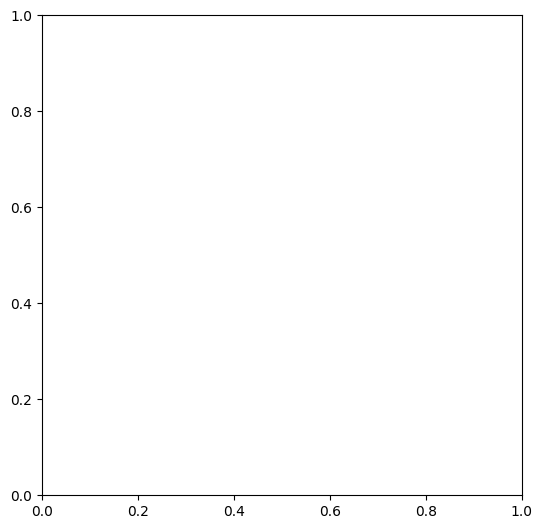

In [29]:
## Plot trial-averaged reaches

# Find unique conditions
conds = trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
conds = [cond for cond in conds if not any(math.isnan(x) for x in cond)]

# Initialize plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond in conds:
    # Find trials in condition
    mask = np.all(trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Extract trial data
    trial_d = dataset.make_trial_data(ignored_trials=(~mask))
    # Average hand position across trials
    traj = trial_d.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    active_target = trial_info[mask].target_pos.iloc[0][int(dataset.trial_info[mask].active_target.iloc[0])]
    reach_angle = np.arctan2(*active_target[::-1])
    # Plot reach
    ax.plot([0, traj[:, 0][-1]], [0, traj[:, 1][-1]], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))

angle_radians = np.radians(350)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(16)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(38)
x_end = 80 * np.cos(angle_radians)
y_end = 80 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(125)
x_end = 50 * np.cos(angle_radians)
y_end = 50 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(175)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(193)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')
'''
angle_radians = np.radians(212)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(232)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(280)
x_end = 100 * np.cos(angle_radians)
y_end = 100 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(329)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=0.7, color='black')

angle_radians = np.radians(0)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

angle_radians = np.radians(90)
x_end = 50 * np.cos(angle_radians)
y_end = 50 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

angle_radians = np.radians(180)
x_end = 140 * np.cos(angle_radians)
y_end = 140 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

angle_radians = np.radians(270)
x_end = 100 * np.cos(angle_radians)
y_end = 100 * np.sin(angle_radians)
ax.plot([0, x_end], [0, y_end], linewidth=1.7, color='navy')

plt.axis('off')
plt.show()

In [ ]:
## Plot trial-averaged reaches

# Find unique conditions
maze_conds = trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
maze_conds = [cond for cond in maze_conds if not any(math.isnan(x) for x in cond)]

orig_conds = {}

fig = plt.figure(figsize=(6, 6))
fig.suptitle('Aligned trials (same length)')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond_idx, cond in enumerate(maze_conds):
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    trial_d = dataset.make_trial_data(align_field='move_onset_time', align_range=(-240, 660), ignored_trials=(~mask))
    traj = trial_d.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    reach_angle = np.arctan2(*trial_info[mask].target_pos.iloc[0][int(trial_info[mask].active_target.iloc[0])][::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
    
    orig_conds[cond_idx] = trial_d.trial_id.drop_duplicates().values

simp_conds = {key: np.concatenate(value) for key, value in simp_conds.items()}
    
plt.axis('off')
plt.show()

In [ ]:
conds = []
for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
            break
            
maze_conds = torch.tensor(maze_conds)
conds = torch.tensor(conds)

print(maze_conds.shape)
print(conds.shape)

In [ ]:
_, cond_counts = torch.unique(conds, return_counts=True)
cond_counts

## Forming trials and label vectors

In [ ]:
#[col for col in trial_data.columns if any(_ in col for _ in ['vel', 'pos', 'force', 'acc', 'target'])]
label_cols = [col for col in trial_data.columns if any(_ in col for _ in ['x', 'y'])]

In [ ]:
label_cols

In [ ]:
# Align the trials arount the move_onset bin with offsets before and after that bin.
y = []
labels = []
target_pos = []
active_target = []
conds = []

# We want total trial length of 900ms, which is 90 time bins.
bins_before_move = 48
bins_after_move = 132

trial_length = bins_before_move + bins_after_move
n_trials = trial_data.shape[0] // trial_length

for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_info = trial_info[trial_info['trial_id'] == trial_id]
            
    # Get the untill movement in ms.
    move_time = (trial_id_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
    # Get the number of bins until movement.
    move_bin = int(move_time // binsize)

    y_heldin_t = torch.tensor(trial.spikes.values)
    y_heldout_t = torch.tensor(trial.heldout_spikes.values)
    
    # Crop the trials arount the move_onset bin with offsets before and after that bin.
    y_t = torch.concat(
        [y_heldin_t[move_bin-bins_before_move:move_bin+bins_after_move, :], y_heldout_t[move_bin-bins_before_move:move_bin+bins_after_move, :]], dim=-1
    )
    
    y.append(y_t.reshape(1, trial_length, n_neurons))
    labels.append(torch.tensor(trial.cursor_pos.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2))
    
    target_pos.append(trial_id_info.target_pos.values[0])
    active_target.append(int(trial_id_info.active_target.values[0]))
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
    
y = torch.concat(y, dim=0)
labels = torch.concat(labels, dim=0)
conds = torch.tensor(conds)
active_target = torch.tensor(active_target)

print(y.shape)
print(labels.shape)
print(conds.shape)
print(len(target_pos))
print(active_target.shape)

### Forming events occurance time bins

In [ ]:
for i, _ in enumerate(trials):
    trial_id = i + n_null_trials
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    target_on = (((trial_id_trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    gocue = (((trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    move_onset = (((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)

In [ ]:
target_bins = []
gocue_bins = []
move_bins = []
event_bins = []

for i, _ in enumerate(trials):
    trial_id = i + n_null_trials
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    # target : go
    delay = (((trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    # go : move
    prep = (((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    
    target_on = (((trial_id_trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    gocue = (((trial_id_trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    move_onset = (((trial_id_trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_id_trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)
    
    target_bins.append(target_on - move_onset + bins_before_move)
    gocue_bins.append(gocue - move_onset + bins_before_move)
    move_bins.append(bins_before_move)

event_bins.append(torch.tensor(target_bins))
event_bins.append(torch.tensor(gocue_bins))
event_bins.append(torch.tensor(move_bins))
event_bins = torch.stack(event_bins)
event_bins.shape

In [ ]:
event_bins = event_bins.permute(1, 0)

event_bins[event_bins < 0] = float('nan')
event_bins[event_bins > bins_before_move + bins_after_move] = float('nan')
event_bins.shape

In [ ]:
event_bins

### Save data splits

In [ ]:
import torch

!mkdir data
save_root_path = 'data/'

train_data, valid_data, test_data = {}, {}, {}
n_trials, seq_len, n_neurons = y.shape
n_valid_trials = 574

# obs: observations
train_data['y_obs'] = torch.Tensor(y[:-n_valid_trials])
valid_data['y_obs'] = torch.Tensor(y[-n_valid_trials:-n_valid_trials // 2])
test_data['y_obs'] = torch.Tensor(y[-n_valid_trials // 2:])

# 'n_bins_enc': Number of time bins used later by in modeling for enconding (default full trial).
# 'n_bins_obs': originaly observed trial length (after alignment)
# Same for 'n_neurons_obs' and 'n_neurons_enc'.
train_data['n_bins_obs'] = valid_data['n_bins_obs'] = test_data['n_bins_obs'] = seq_len
train_data['n_bins_enc'] = valid_data['n_bins_enc'] = test_data['n_bins_enc'] = seq_len
train_data['n_neurons_obs'] = valid_data['n_neurons_obs'] = test_data['n_neurons_obs'] = n_neurons
train_data['n_neurons_enc'] = valid_data['n_neurons_enc'] = test_data['n_neurons_enc'] = n_neurons

# Save a 1D array for event bins for each data split, for each trial, for each event.
# Note: the o here in event_bins[0] is the session-animal group.
for event_id, event in enumerate(['targrt_on_bin', 'go_cue_bin', 'move_onset_bin']):
    train_data[event] = torch.Tensor(np.array(event_bins[:-n_valid_trials, event_id]))
    valid_data[event] = torch.Tensor(np.array(event_bins[-n_valid_trials:-n_valid_trials // 2, event_id]))
    test_data[event] = torch.Tensor(np.array(event_bins[-n_valid_trials // 2:, event_id]))

train_data['hand_vel'] = torch.Tensor(np.array(labels[:-n_valid_trials, :, :]))
valid_data['hand_vel'] = torch.Tensor(np.array(labels[-n_valid_trials:-n_valid_trials // 2, :, :]))
test_data['hand_vel'] = torch.Tensor(np.array(labels[-n_valid_trials // 2:, :, :]))

train_data['conds'] = torch.Tensor(np.array(conds[:-n_valid_trials]))
valid_data['conds'] = torch.Tensor(np.array(conds[-n_valid_trials:-n_valid_trials // 2]))
test_data['conds'] = torch.Tensor(np.array(conds[-n_valid_trials // 2:]))

train_data['target_pos'] = target_pos[:-n_valid_trials]
valid_data['target_pos'] = target_pos[-n_valid_trials:-n_valid_trials // 2]
test_data['target_pos'] = target_pos[-n_valid_trials // 2:]

train_data['active_target'] = torch.Tensor(np.array(active_target[:-n_valid_trials]))
valid_data['active_target'] = torch.Tensor(np.array(active_target[-n_valid_trials:-n_valid_trials // 2]))
test_data['active_target'] = torch.Tensor(np.array(active_target[-n_valid_trials // 2:]))

'''
for label_id, label in enumerate(label_cols):
    train_data[f'{label[0]}_{label[1]}'] = torch.Tensor(np.array(labels[:-n_valid_trials, :, :]))
    valid_data[f'{label[0]}_{label[1]}'] = torch.Tensor(np.array(labels[-n_valid_trials:-n_valid_trials // 2, :, :]))
    test_data[f'{label[0]}_{label[1]}'] = torch.Tensor(np.array(labels[-n_valid_trials // 2:, :, :]))
'''
torch.save(train_data, save_root_path + f'data_train_{binsize}ms.pt')
torch.save(valid_data, save_root_path + f'data_valid_{binsize}ms.pt')
torch.save(test_data, save_root_path + f'data_test_{binsize}ms.pt')

print('Data splits (train/valid/test) saved into the "data" folder.')

## Load data splits

In [ ]:
data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Data dimensions
n_train_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]
n_time_bins_enc = train_data['n_time_bins_enc']

batch_sz_train = list(y_train_obs.shape)[:-1]
batch_sz_valid = list(y_valid_obs.shape)[:-1]
batch_sz_test = list(y_test_obs.shape)[:-1]

print("# training trials: {0}".format(n_train_trials))
print("# validation trials: {0}".format(n_valid_trials))
print("# testing trials: {0}".format(n_test_trials))
print("# neurons: {0}".format(n_neurons_obs))
print("# time bins: {0}".format(n_time_bins))
print("# time bins used for forcasting: {0}".format(cfg.n_bins_bhv))
print("# predicted time bins: {0}".format(n_time_bins - cfg.n_bins_bhv))

### Reach variability

In [ ]:
conds_ids, cond_counts = torch.unique(conds, return_counts=True)
cond_counts

In [ ]:
top_cs, top_ids = torch.topk(cond_counts, 5)
top_ids

In [ ]:
trial_info['num_targets']

In [ ]:
# Trial-averged 108 reach conditions

fig = plt.figure(figsize=(6, 6))
fig.suptitle('Aligned trials (same length)')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond_idx, cond in enumerate([cond for cond in trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist() if not any(math.isnan(x) for x in cond)]):
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    trial_d = dataset.make_trial_data(align_field='move_onset_time', align_range=(-240, 660), ignored_trials=(~mask))
    traj = trial_d.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # Determine reach angle for color
    reach_angle = np.arctan2(*trial_info[mask].target_pos.iloc[0][int(trial_info[mask].active_target.iloc[0])][::-1])
    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
    
plt.axis('off')
plt.savefig('trial_averged_reaches_108')
plt.show()

In [ ]:
y_data = y
y_vel = labels
y_conds = conds
y_t_pos = target_pos
act_t = active_target

In [ ]:
def get_cond_trials(y_vel, y_conds):
    psth = np.zeros((len(conds_ids), y_vel.shape[1], y_vel.shape[2]))

    for cond in conds_ids:
        mask = y_conds == cond
        psth[cond, :, :] = y_vel[mask, :, :].mean(axis=0)
    
    return psth

def calc_var_to_mean_ratio(psth):
    v_m_ratio =  np.sum((psth.var(axis=0)) / (psth.mean(axis=0)), axis=0)
    
    return(np.nan_to_num(v_m_ratio, nan=0))

In [ ]:
psth = get_cond_trials(y_vel, y_conds)

In [ ]:
psth.shape

In [ ]:
vmr = calc_var_to_mean_ratio(psth)

In [ ]:
vmr

In [ ]:
psth[0, 0, :]

In [ ]:
# Compute the variance for each tensor along the specified dimension
var = [t.var(axis=0).mean().item() for t in psth[0, :, :]]

In [ ]:
var

In [ ]:
np.array(var).shape

In [ ]:
psth[0, :, :].shape

In [ ]:


# Sort the tensors based on the calculated variances
sorted_tensors = [tensor for _, tensor in sorted(zip(variances, tensors), key=lambda x: x[0])]

# Output the sorted tensors
for i, tensor in enumerate(sorted_tensors):
    print(f"Tensor {i+1}:\n{tensor}\n")

In [ ]:
psth[0, :, :]

In [ ]:
def load_data(datapath, binsize, split_heldout):
    pass

def get_average_reach(df, cond):
    pass

def get_reach_variaiance(df, cond):
    pass

def get_hit_accuracy(df, cond):
    pass

def get_reach_deviation(df, cond):
    pass

In [ ]:
import numpy as np
import math

from typing import Literal

import torch

from itertools import product
from nlb_tools.nwb_interface import NWBDataset


def process_nwb(data_folder_path: str,
                split_heldout:bool,
                session: int,
                animal: int,
                binsize: int,
                align_event: Literal['target_on_time', 'go_cue_time', 'move_onset_time']
                bins_before: int,
                bins_after: int,
                obj: Literal['hand', 'cursor'],
                mes: Literal['vel', 'pos']
                save_root_path:str
               ) -> pd.DataFrame:
    
    
    
    output_df = pd.DataFrame(
        {
            'session_id': pd.Series(dtype=int),
            'animal_id': pd.Series(dtype=int),
            'trial_id': pd.Series(dtype=int),

            'is_task_success': pd.Series(dtype=int),
            'is_correct_reach': pd.Series(dtype=int),

            'spikes': pd.Series(dtype=object),

            'hand_vel': pd.Series(dtype=object),
            'cursor_vel': pd.Series(dtype=object),
            'hand_pos': pd.Series(dtype=object),
            'cursor_pos': pd.Series(dtype=object),

            'hand_pos_cumsum_vel': pd.Series(dtype=object),
            'cursor_pos_cumsum_vel': pd.Series(dtype=object),

            'maze_condition': pd.Series(dtype=int),
            'num_barriers': pd.Series(dtype=int),
            'num_targets': pd.Series(dtype=int),
            'reach_angle_rad': pd.Series(dtype=float),
            'reach_angle_deg': pd.Series(dtype=float),

            'typical_reach': {
                'reach': pd.Series(dtype=torch.FloatTensor)
                'mean': pd.Series(dtype=float),
                'variance': pd.Series(dtype=float),
            },

            'average_reach': pd.Series(dtype=torch.FloatTensor),
            'deviation_from_average_reach': pd.Series(dtype=float),

            'true_target_pos': {
                'x': pd.Series(dtype=float),
                'y': pd.Series(dtype=float),
            },
            'target_hit_accuracy': pd.Series(dtype=float),
            'target_size': pd.Series(dtype=float),

            'target_on_time': pd.Series(dtype=int),
            'target_on_bin': pd.Series(dtype=int),
            'go_cue_time': pd.Series(dtype=int),
            'go_cue_bin': pd.Series(dtype=int),
            'move_starts_time': pd.Series(dtype=int),
            'move_starts_bin': pd.Series(dtype=int),
            'move_ends_time': pd.Series(dtype=int),
            'move_ends_bin': pd.Series(dtype=int),

            'intertrial_interval': pd.Series(dtype=float),
            'reaction_time': pd.Series(dtype=float),
            'delay_time': pd.Series(dtype=float),
            'move_execution_time': pd.Series(dtype=float),
            
            'trial_ends_time': pd.Series(dtype=float),
        }
    )
    
    dataset = NWBDataset(datapath, split_heldout=split_heldout)
    dataset.resample(target_bin=binsize)
    trials_info = dataset.trial_info
    print(f'Total number of trials: {len(trial_info)}')
    n_null_trials = trial_info.isnull().sum()['success']
    print(f"Including {n_null_trials} null trials")
    
    # Combining the number of columns in the 'spikes' field with those in the 'heldout_spikes' field gives the total number of neurons.
    n_neurons = dataset.data.spikes.values.shape[1] + dataset.data.heldout_spikes.values.shape[1] if split_heldout else dataset.data.spikes.values.shape[1]
    print(f'There are {n_neurons} neurons')

    trial_data = dataset.make_trial_data()
    trials = [trial[1] for trial in trial_data.groupby('trial_id')]
    label_cols = [col for col in trial_data.columns if any(_ in col for _ in ['x', 'y'])]

    # Find unique conditions
    maze_conds = [cond for cond in trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist() if
                  not any(math.isnan(x) for x in cond)]

    orig_conds = {}

    # Loop over conditions and compute average trajectory
    for cond_idx, cond in enumerate(maze_conds):
        # Find trials in condition
        mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
        trial_d = dataset.make_trial_data(ignored_trials=(~mask))
        orig_conds[cond_idx] = trial_d.trial_id.drop_duplicates().values

    maze_conds = torch.tensor(maze_conds)
    maze_conds = torch.tensor(maze_conds)

    # Align the trials arount the move_onset bin with offsets before and after that bin.

    trial_length = bins_before + bins_after
    n_trials = trial_data.shape[0] // trial_length

    for trial_id, trial in trial_data.groupby('trial_id'):
        trial_info = trials_info[trials_info['trial_id'] == trial_id]
        
        row = {col: None for col in output_df.columns}

        # Get the untill movement in ms.
        move_time = (trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (
                    trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
        # Get the number of bins until movement.
        move_bin = int(move_time // binsize)

        # Crop the trials arount the move_onset bin with offsets before and after that bin.
        if split_heldout:
            row.spikes = spikes = torch.concat(
                [torch.tensor(trial.spikes.values)[move_bin - bins_before:move_bin + bins_after, :], torch.tensor(trial.heldout_spikes.values)[move_bin - bins_before:move_bin + bins_after, :]],
                dim=-1)
        else:
            row.spikes = spikes = torch.tensor(trial.spikes.values)
        
        row.session_id = session
        row.animal_id = animal
        row.trial_id = trial_id
        
        row.is_task_success = trial_info.success
        row.is_correct_reach = trial_info.correct_reach
        
        row.hand_vel = torch.tensor(trial.hand_vel.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2)
        row.cursor_vel = torch.tensor(trial.cursor_vel.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2)
        row.hand_pos = torch.tensor(trial.hand_pos.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2)
        row.cursor_pos = torch.tensor(trial.cursor_pos.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2)
        
        row.hand_pos_cumsum_vel = torch.tensor(trial.hand_pos.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2)
        row.cursor_pos_cumsum_vel = torch.tensor(trial.cursor_pos.values[move_bin-bins_before_move:move_bin+bins_after_move, :]).reshape(1, trial_length, 2)
        
        row.num_barriers = trial_info.num_barriers.values[0]
        row.num_targets = trial_info.num_targets.values[0]
        row.true_target_pos = trial_info.target_pos.values[0][int(trial_id_info.active_target.values[0])]
        
        row.intertrial_interval = (trials_info[trials_info['trial_id'] == trial_id+1]['start_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['end_time'].iloc[0] / np.timedelta64(1, 'ms'))
        row.reaction_time = trial_info.rt
        row.delay_time = trial_info.delay
        row.move_execution_time = (trial_info['move_ends_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['move_begins_time'].iloc[0] / np.timedelta64(1, 'ms'))
        
        if 'maze_condition' in dataset:
            row.maze_condition = maze_condition
        else:
            for cond, trial_ids in orig_conds.items():
                if trial_id in trial_ids:
                    row.maze_condition = cond
                
        row.target_on_time = (trial_info['target_presentation_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
        row.target_on_bin = target_on_time
        row.go_cue_time = (trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
        row.go_cue_bin = int(np.ceil(go_cue_time / binsize))
        row.move_onset_time = (trial_info['move_begins_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))
        row.move_onset_bin = int(np.ceil()
        row.move_ends_time = 
        row.move_ends_bin = int(np.ceil()
        
        row.trial_ends_time = (trial_info['end_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['end_time'].iloc[0] / np.timedelta64(1, 'ms'))

        target_on = (((trial_info['target_on_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)

        gocue = (((trial_info['go_cue_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)

        move_onset = (((trial_info['move_onset_time'].iloc[0] / np.timedelta64(1, 'ms')) - (trial_info['start_time'].iloc[0] / np.timedelta64(1, 'ms'))) // binsize)

        target_bins.append(target_on - move_onset + bins_before)
        gocue_bins.append(gocue - move_onset + bins_before)
        move_bins.append(bins_before)
                                
        

In [ ]:
td = ds.make_trial_data()
ti = ds.trial_info

In [ ]:
td.shape

In [ ]:
for column in td.columns:
    print(column)

In [ ]:
for column in ti.columns:
    print(column)

In [ ]:
dir(ds)

In [ ]:
ds.data.columns

In [ ]:
ds.data.shape

In [ ]:
ds.calculate_onset()

In [ ]:
td.shape

In [ ]:
len(ti)

In [ ]:
ti

In [ ]:
n_null_trials = ti.isnull().sum()['task_success']
n_neurons = ds.data.spikes.values.shape[1]

print(f'number of neurons: {n_neurons}')
print(f'total number of trials: {len(ti)}')
print(f'number of null trials: {n_null_trials}')